In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from KDTree import Datapoint
from KDTree import KDTree

In [2]:
data_colors = {str(i): random.uniform(1,10) for i in range(1, 201)}

datapoints = [Datapoint([random.randint(1, 100), random.randint(1, 100)], color=random.choice( list(data_colors.keys()) ) ) for i in range(100)]

In [3]:
tree = KDTree()
tree.build_tree(datapoints, data_colors)
datapoints.sort(key=lambda pts: pts.coordinate)

In [4]:
test3_colors = {str(i): 1 for i in range(1,3)}
test3_datapoints = [Datapoint([i], color='1') for i in range(1, 7)]
test3_datapoints[2].color = '2'
test3_datapoints[3].color = '2'
test3_datapoints[4].color = '2'
test3_tree = KDTree()
test3_tree.build_tree(test3_datapoints, test3_colors)

In [5]:
x = test3_tree.level2_random_selection( ([1.5, -10], [6.5, 1.4]), test3_datapoints )

In [6]:
test1_colors = {str(i): (500/np.exp(0.5 * i)) for i in range(1, 11)}
test1_datapoints = [Datapoint([i], color= str( ( (i-1)%10 ) + 1 ) )for i in range(1, 1001)]
test1_tree = KDTree()
test1_tree.build_tree(test1_datapoints, test1_colors)

In [7]:
test1_result = {str(i): 0 for i in range(1, 11)}
for i in range(1000):
    x = test1_tree.level2_random_selection( ([40.5, -10], [83.5, 40.4]), test1_datapoints )
    test1_result[x] = test1_result[x] + 1

In [8]:
test1_result

{'1': 479,
 '2': 300,
 '3': 64,
 '4': 45,
 '5': 49,
 '6': 26,
 '7': 16,
 '8': 17,
 '9': 2,
 '10': 2}

Text(0.5, 1.0, 'Test1')

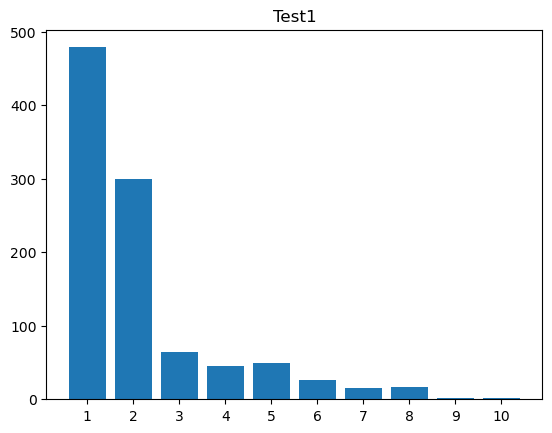

In [9]:
plt.bar(test1_result.keys(), test1_result.values())
plt.title('Test1')

In [10]:
test2_colors = {str(i): (500/np.exp(0.5 * i)) for i in range(1, 11)}
test2_colors['0'] = 100000000
test2_datapoints = [Datapoint([i], color= '1') for i in range(1, 1001)]
for i in range(1000):
    if i < 40 or i > 82:
        test2_datapoints[i].color = str(1)
    elif i <= 43:
        test2_datapoints[i].color = str(i-39)
    elif i < 78:
        test2_datapoints[i].color = '5'
    else:
        test2_datapoints[i].color = str(88-i)
   
test2_tree = KDTree()
test2_tree.build_tree(test2_datapoints, test2_colors)

In [11]:
test2_result = {str(i): 0 for i in range(1, 11)}
for i in range(1000):
    x = test2_tree.level2_random_selection( ([40.5, -10], [83.5, 40.4]), test2_datapoints )
    test2_result[x] = test2_result[x] + 1

In [12]:
test2_result

{'1': 760,
 '2': 68,
 '3': 23,
 '4': 13,
 '5': 56,
 '6': 49,
 '7': 16,
 '8': 4,
 '9': 7,
 '10': 4}

Text(0.5, 1.0, 'Test2')

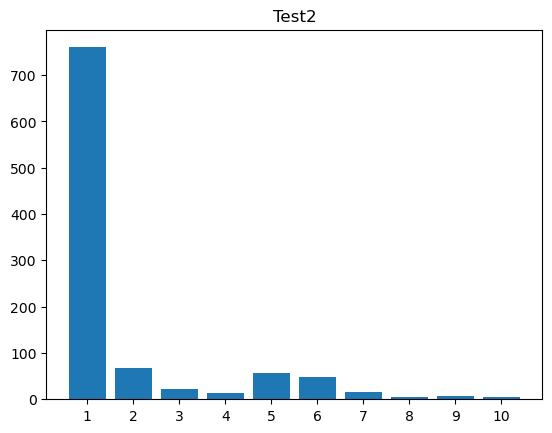

In [13]:
plt.bar(test2_result.keys(), test2_result.values())
plt.title('Test2')